In [ ]:
# 📦 Librerías estándar
import os
import time
import joblib
import numpy as np
import pandas as pd

# 📊 Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# ⚙️ Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

# 🤖 Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# 📈 Métricas de evaluación
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, accuracy_score, f1_score, roc_auc_score
)

# ⚖️ Técnicas de balanceo
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler


## BALANCEO DE CLASES

In [39]:
path = './datasets/mitbih_train.csv'
df = pd.read_csv(path, header=None)
df.rename(columns={187:"label"}, inplace=True) #renombrar la columna de label

Distribución de clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Porcentaje por clase:
 label
0.0    82.77
4.0     7.35
2.0     6.61
1.0     2.54
3.0     0.73
Name: proportion, dtype: float64


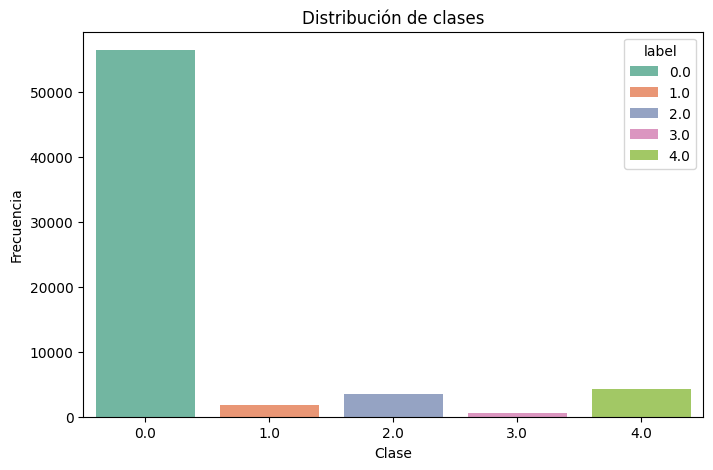

In [40]:
# Conteo de clases
class_counts = df['label'].value_counts()
print("Distribución de clases:\n", class_counts)

# Porcentaje de cada clase
class_percentages = df['label'].value_counts(normalize=True) * 100
print("\nPorcentaje por clase:\n", class_percentages.round(2))

# Visualización
plt.figure(figsize=(8, 5))
sns.countplot(x='label', hue='label', data=df, palette='Set2', )
plt.title('Distribución de clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


Al revisar nuestro dataset de training, observamos que la proporción de labels de la clase 0 es considerablemente mayor, (el 82.7%) del total de los datos, que las otras clases. Inclusive hay una clase que representa menos del 1% (clase 3). Las otras 3 clases, contienen entre el 2% y 7% de los datos. Por lo anterior, se infiere que el dataset está desbalanceado.

### SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE es una técnica de sobremuestreo que genera nuevas instancias sintéticas de la clase minoritaria en lugar de simplemente replicar las existentes. Lo hace interpolando entre una muestra de la clase minoritaria y sus vecinos más cercanos en el espacio de características. Esto ayuda a crear un conjunto de datos más equilibrado sin sobreajustar el modelo a duplicados, como sucede con el sobremuestreo clásico, y resulta muy útil cuando el desequilibrio entre clases puede llevar al modelo a ignorar la clase minoritaria.

**Fundamento matemático**  
Para una muestra minoritaria $x_i$ y uno de sus $k$ vecinos más cercanos $x_{zi}$, se genera un punto sintético $x_{\text{synt}}$ al interpolar linealmente ambos vectores con un factor aleatorio $\lambda \in [0,1]$:

$$
x_{\text{synt}} = x_i + \lambda \cdot (x_{zi} - x_i).
$$


In [41]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']

# Instanciar SMOTE
sm = SMOTE(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_res, y_res = sm.fit_resample(X, y)

# Mostrar la forma de los datos antes y después
print("Tamaño de X original:", X.shape)
print("Distribución original de las clases:\n", y.value_counts())

print("\nTamaño de X tras SMOTE:", X_res.shape)
print("Distribución de las clases tras SMOTE:\n", y_res.value_counts())

Tamaño de X original: (87554, 187)
Distribución original de las clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Tamaño de X tras SMOTE: (362355, 187)
Distribución de las clases tras SMOTE:
 label
0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: count, dtype: int64


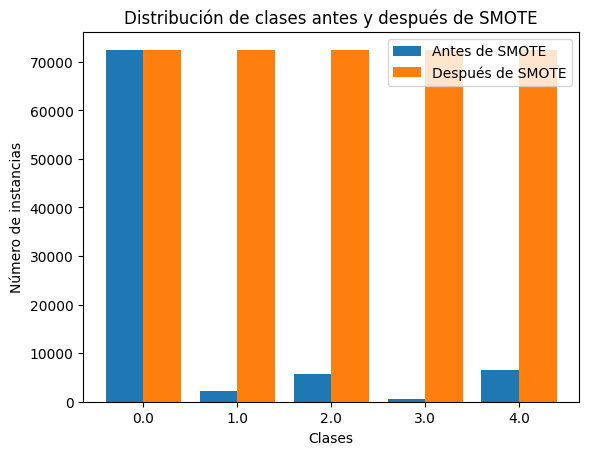

In [42]:
# ===== Gráfica comparativa =====
# Obtener conteos de cada clase antes y después
before_counts = y.value_counts().sort_index()
after_counts = y_res.value_counts().sort_index()
clases = before_counts.index

# Crear posición para cada grupo de barras
import numpy as np
x = np.arange(len(clases))
width = 0.4  # Ancho de cada barra

plt.bar(x - width/2, before_counts, width=width, label='Antes de SMOTE')
plt.bar(x + width/2, after_counts, width=width, label='Después de SMOTE')

plt.xlabel('Clases')
plt.ylabel('Número de instancias')
plt.title('Distribución de clases antes y después de SMOTE')
plt.xticks(x, clases)  # Etiquetas en el eje X con los nombres de las clases
plt.legend()
plt.show()

### **Undersampling (submuestreo)** 

Es una técnica para manejar el desbalance de clases **reduciendo** el número de instancias de la clase mayoritaria. Con ello se busca equilibrar la proporción de ambas clases y evitar que el modelo ignore la clase minoritaria.

Supongamos que tenemos:

- Clase mayoritaria $ \mathcal{C}_{\text{maj}} $ con $ N $ instancias.
- Clase minoritaria $ \mathcal{C}_{\text{min}} $ con $ M $ instancias (donde $ M \ll N $).

La idea de **undersampling** es escoger aleatoriamente (o con algún criterio específico) un subconjunto

$$
\mathcal{C}_{\text{maj}}' \subseteq \mathcal{C}_{\text{maj}}
$$

con $ N' $ instancias, de modo que:

$$
N' \approx M 
\quad \text{o} \quad 
N' < N 
\quad (\text{con el fin de equilibrar}).
$$

El nuevo conjunto de datos se convierte en:

$$
\mathcal{D}' = \mathcal{C}_{\text{maj}}' \cup \mathcal{C}_{\text{min}}.
$$


In [43]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']

# Instanciar UnderSampler
sm = RandomUnderSampler(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_res, y_res = sm.fit_resample(X, y)

# Mostrar la forma de los datos antes y después
print("Tamaño de X original:", X.shape)
print("Distribución original de las clases:\n", y.value_counts())

print("\nTamaño de X tras SMOTE:", X_res.shape)
print("Distribución de las clases tras SMOTE:\n", y_res.value_counts())

Tamaño de X original: (87554, 187)
Distribución original de las clases:
 label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Tamaño de X tras SMOTE: (3205, 187)
Distribución de las clases tras SMOTE:
 label
0.0    641
1.0    641
2.0    641
3.0    641
4.0    641
Name: count, dtype: int64


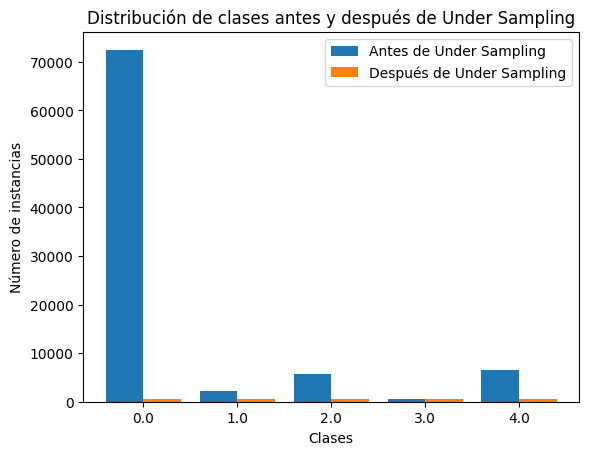

In [44]:
# ===== Gráfica comparativa =====
# Obtener conteos de cada clase antes y después
before_counts = y.value_counts().sort_index()
after_counts = y_res.value_counts().sort_index()
clases = before_counts.index

# Crear posición para cada grupo de barras
import numpy as np
x = np.arange(len(clases))
width = 0.4  # Ancho de cada barra

plt.bar(x - width/2, before_counts, width=width, label='Antes de Under Sampling')
plt.bar(x + width/2, after_counts, width=width, label='Después de Under Sampling')

plt.xlabel('Clases')
plt.ylabel('Número de instancias')
plt.title('Distribución de clases antes y después de Under Sampling')
plt.xticks(x, clases)  # Etiquetas en el eje X con los nombres de las clases
plt.legend()
plt.show()

### ADASYN (Adaptive Synthetic Sampling)

ADASYN es una extensión de SMOTE que también crea muestras sintéticas, pero con un enfoque adaptativo: se enfoca en generar más datos sintéticos en las regiones donde la clase minoritaria es más difícil de aprender (es decir, donde hay mayor presencia de la clase mayoritaria). Al centrar la generación de datos en estas áreas críticas, el modelo es reforzado específicamente en los límites más complejos.

**Fundamento matemático**

1. **Dificultad local** de la muestra minoritaria $x_i$:

   $$
   r_i = \frac{\text{(número de vecinos de la clase mayoritaria)}}{k},
   $$

   donde $k$ es la cantidad total de vecinos que se consideran alrededor de $x_i$.

2. **Número de instancias sintéticas $G_i$** a generar para cada muestra $x_i$:

   $$
   G_i = \frac{r_i}{\sum_{j=1}^{n} r_j} \cdot G,
   $$

   donde $n$ es el número de muestras minoritarias y $G$ es la cantidad total de instancias sintéticas deseadas.

3. **Generación de nuevas muestras sintéticas**, igual que en SMOTE:

   $$
   x_{\text{synt}} = x_i + \lambda \cdot (x_{zi} - x_i),
   $$

   usando un factor aleatorio $\lambda \in [0,1]$.

De este modo, ADASYN concentra más muestras en las zonas donde la clase minoritaria es más complicada de aprender, a diferencia de SMOTE, que lo hace de forma más uniforme.

---





In [45]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']

# Instanciar ADASYN (puedes ajustar parámetros como n_neighbors, sampling_strategy, etc.)
adasyn = ADASYN(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_res, y_res = adasyn.fit_resample(X, y)

# Verificar la nueva distribución de clases
print("Distribución de las clases antes de ADASYN:")
print(y.value_counts())

print("\nDistribución de las clases después de ADASYN:")
print(y_res.value_counts())

Distribución de las clases antes de ADASYN:
label
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

Distribución de las clases después de ADASYN:
label
2.0    72684
3.0    72486
0.0    72471
4.0    72434
1.0    72189
Name: count, dtype: int64


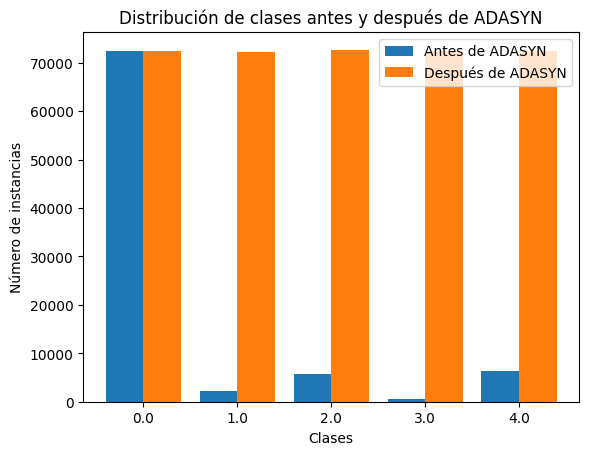

In [46]:
# ===== Gráfica comparativa =====
# Obtener conteos de cada clase antes y después
before_counts = y.value_counts().sort_index()
after_counts = y_res.value_counts().sort_index()
clases = before_counts.index

# Crear posición para cada grupo de barras
import numpy as np
x = np.arange(len(clases))
width = 0.4  # Ancho de cada barra

plt.bar(x - width/2, before_counts, width=width, label='Antes de ADASYN')
plt.bar(x + width/2, after_counts, width=width, label='Después de ADASYN')

plt.xlabel('Clases')
plt.ylabel('Número de instancias')
plt.title('Distribución de clases antes y después de ADASYN')
plt.xticks(x, clases)  # Etiquetas en el eje X con los nombres de las clases
plt.legend()
plt.show()

### class_weight='balanced' (Scikit-learn)

En lugar de modificar la distribución de datos, `class_weight='balanced'` asigna automáticamente un peso mayor a las clases menos representadas durante el entrenamiento de modelos como `LogisticRegression`, `RandomForestClassifier` o `SVC`. De esta forma, penaliza más los errores cometidos en las clases con menos muestras, forzando al modelo a prestarles mayor atención. Es una manera simple y efectiva de atenuar el sesgo sin alterar directamente los datos.

**Fundamento matemático**  
En Scikit-learn, el peso asignado a la clase $j$ se calcula como:

$$
w_j = \frac{n}{k \cdot n_j},
$$

donde:
- $n$ es el número total de muestras,
- $k$ es el número total de clases,
- $n_j$ es la cantidad de instancias de la clase $j$.

Mientras más escasa sea una clase (menor $n_j$), mayor será su peso $w_j$, lo que “protege” la clase minoritaria de ser ignorada.


In [47]:
X_train = df.drop('label', axis=1)
y_train = df['label']

path_test = './datasets/mitbih_test.csv'
test = pd.read_csv(path_test, header=None)
test.rename(columns={187:"label"}, inplace=True) #renombrar la columna de label

X_test = test.drop('label', axis=1)
y_test = test['label']

In [48]:
# Instanciar un RandomForestClassifier con class_weight='balanced'
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = clf.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     18118
         1.0       0.97      0.59      0.73       556
         2.0       0.98      0.88      0.93      1448
         3.0       0.82      0.58      0.68       162
         4.0       1.00      0.94      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.95      0.80      0.86     21892
weighted avg       0.97      0.97      0.97     21892



## Pipeline con balanceo de clases

### Usando SMOTE

A continuación se ilustra, la implementación del balanceo de clases y busqueda de hiperparametros utilizando Pipelines.

La librería Sklearn no permite el balanceo de clases integrado en el Pipeline, por lo que se realizará por separado. El balance de clases siempre se debe realizar despues de dividir los datos en train y test, para evitar filtrar información del test set hacia el train set, lo que introduce data leakage.

In [49]:
def evaluate_and_save_model(grid_search_fitted, model_name, X_test, y_test, training_time):
    """
    Evalúa el mejor modelo de un GridSearchCV y guarda sus resultados.

    Parámetros:
    - grid_search_fitted (GridSearchCV): GridSearchCV ya entrenado.
    - model_name (str): Nombre del modelo (prefijo para archivos).
    - X_test, y_test: Datos de prueba.
    - training_time (float): Tiempo de entrenamiento.

    Salida:
    - None. Guarda dos archivos .pkl en carpetas /models y /results.
    """

    # Crear directorios si no existen
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # Mejor estimador
    best_estimator = grid_search_fitted.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Probabilidades y AUC
    if hasattr(best_estimator, "predict_proba"):
        y_pred_proba = best_estimator.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    elif hasattr(best_estimator, "decision_function"):
        y_pred_proba = best_estimator.decision_function(X_test)
        auc = np.nan
    else:
        y_pred_proba = None
        auc = np.nan

    # Métricas
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Resultados a guardar
    results = {
        'precision_test': precision,
        'recall_test': recall,
        'accuracy_test': accuracy,
        'f1_score_test': f1,
        'confusion_matrix': cm,
        'y_pred_prob': y_pred_proba,
        'auc_test': auc,
        'classification_report': report,
        'cpu_time': training_time,
        'best_params': grid_search_fitted.best_params_,
        'best_recall_cv': grid_search_fitted.best_score_,
        'cv_results': grid_search_fitted.cv_results_
    }

    # Guardar resultados y modelo
    joblib.dump(results, f"results/{model_name}_results.pkl")
    joblib.dump(best_estimator, f"models/best_{model_name}_model.pkl")
    print(f"✅ Modelo y resultados guardados en:\n- models/best_{model_name}_model.pkl\n- results/{model_name}_results.pkl")


In [50]:
# Separar características (X) y etiqueta (y)
X = df.drop('label', axis=1)
y = df['label']



In [51]:
# Instanciar SMOTE
sm = SMOTE(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_train_bal, y_train_bal = sm.fit_resample(X, y)

A continuación, se creará el Pipeline para:
- Realizar GridSearch con Cross validation para un arbol de clasificación

El escalado de variables se dejara comentado debido a que ya las columnas del dataset se encuentran con valores entre 0 y 1.

In [52]:
#2. Modelo SVC
#svc_model = SVC(random_state=42, probability=True)
tree_model = DecisionTreeClassifier(random_state=42)


#3. Instanciar el Pipe
pipe = Pipeline([
  # ("scaler",StandardScaler()), #Escalador
  #("model", svc_model) #Modelo #
  ("model", tree_model) #Modelo
])

#Fit del Pipe con clases balanceadas - Si no quiero hacer GridSearch puedo finalizar aquí
#pipe.fit(X_train_bal, y_train_bal)

#4. ---- GridSearch ----
#a.  Definimos parametros del GS

tree_param_grid = {
    'model__max_depth': [20],
    'model__min_samples_split': [5],
    'model__criterion': ['gini', 'entropy'],
}

#b. Creamos el GridSearch
scorer = "recall_macro"
grid = GridSearchCV(pipe, param_grid= tree_param_grid , cv=5, scoring= scorer)

#5. Se hace Fit al Grid

# Entrenamiento y ajuste del modelo
start_time_svc = time.time()
grid.fit(X_train_bal, y_train_bal)
training_time_svc = time.time() - start_time_svc



In [53]:
# Nombre del modelo
model_name = "tree"

# Evaluación y guardado del modelo
evaluate_and_save_model(grid,model_name, X_test, y_test, training_time_svc)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

✅ Modelo y resultados guardados en:
- models/best_tree_model.pkl
- results/tree_results.pkl
Best cross-validation accuracy: 0.98
Test set score: 0.85
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_split': 5}


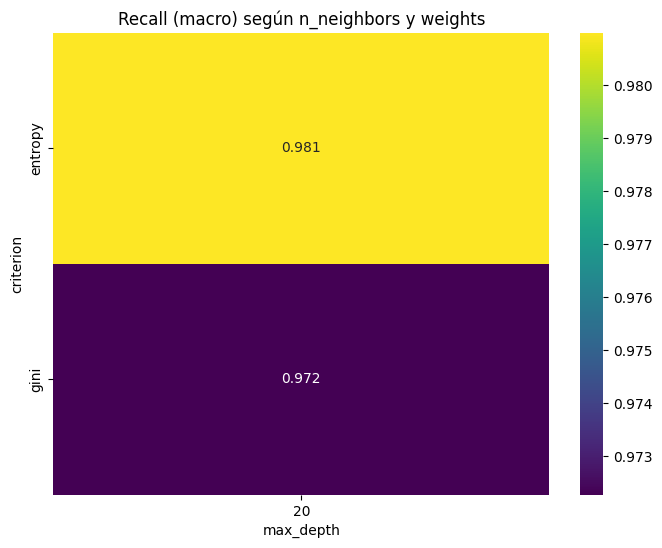

In [54]:
tree_results = joblib.load("results/tree_results.pkl")
cv_results_df = pd.DataFrame(tree_results['cv_results'])

pivot = cv_results_df.pivot_table(index='param_model__criterion',
                                  columns='param_model__max_depth',
                                  values='mean_test_score')
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Recall (macro) según n_neighbors y weights")
plt.xlabel("max_depth")
plt.ylabel("criterion")
plt.show()

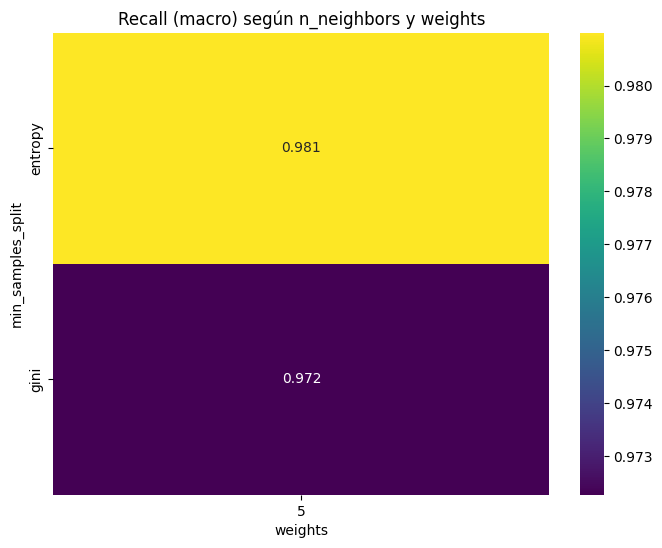

In [55]:
pivot = cv_results_df.pivot_table(index='param_model__criterion',
                                  columns='param_model__min_samples_split',
                                  values='mean_test_score')
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Recall (macro) según n_neighbors y weights")
plt.xlabel("weights")
plt.ylabel("min_samples_split")
plt.show()

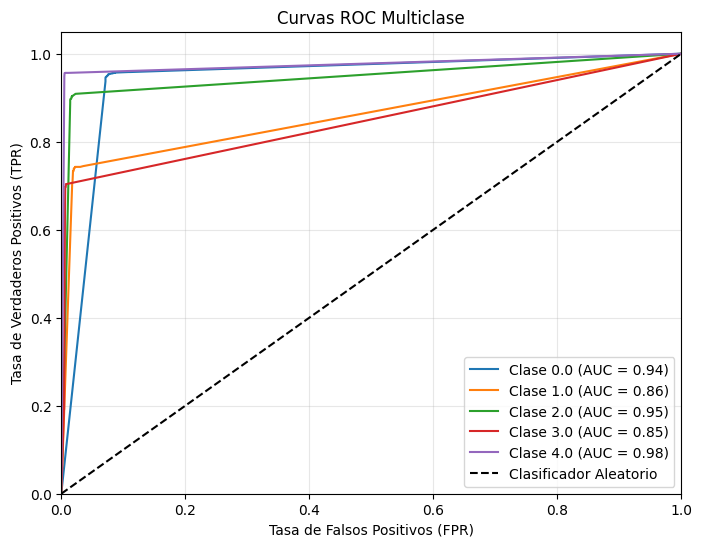

In [56]:
from sklearn.metrics import roc_curve, auc # Dejarlo aquí

y_pred_proba = tree_results['y_pred_prob']

# Binarización de las clases
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Inicialización de diccionarios para almacenar métricas
fpr, tpr, roc_auc = {}, {}, {}

# Cálculo de las curvas ROC y AUC
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Clase {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Gráfica de la línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

Las curvas ROC muestran un buen desempeño general:

- Clase 4.0 (AUC = 0.98): Excelente discriminación.

- Clase 2.0 (AUC = 0.95) y Clase 0.0 (AUC = 0.94): Muy buen rendimiento.

- Clase 1.0 (AUC = 0.86) y Clase 3.0 (AUC = 0.85): Más débiles pero aceptables tras aplicar SMOTE.

La curva ROC sugiere que el modelo tiene buena capacidad de discriminación en general. La mejora en clases minoritarias indica que SMOTE ayudó a balancear los datos, aunque no logró completamente igualar el desempeño de las clases mayoritarias.



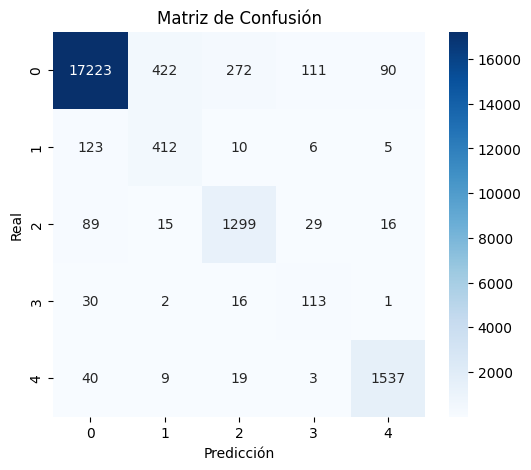

In [57]:
# Matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(tree_results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

- Se observa un muy buen desempeño para la clase 0 con 17,223 aciertos.

- Las clases 1, 3 y 4 muestran algunas confusiones, especialmente:

  - Clase 1 confundida con la clase 0.

  - Clase 3 tiene aciertos bajos (113) y confusión con clase 0.

  - Clase 4 tiene buena precisión pero aún hay errores hacia clase 0 y clase 2.

Aunque SMOTE mejoró el recall de las clases minoritarias, sigue habiendo cierta confusión hacia la clase mayoritaria (0.0), algo esperado cuando hay mucha desproporción en los datos originales.

In [58]:
print("Reporte de Clasificación:\n", tree_results["classification_report"])

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.97     18118
         1.0       0.48      0.74      0.58       556
         2.0       0.80      0.90      0.85      1448
         3.0       0.43      0.70      0.53       162
         4.0       0.93      0.96      0.94      1608

    accuracy                           0.94     21892
   macro avg       0.73      0.85      0.77     21892
weighted avg       0.95      0.94      0.94     21892



- Accuracy global: 0.94
- Macro avg: F1 = 0.77 → afecta por clases 1 y 3
- Weighted avg: F1 = 0.94 → dominada por clase 0


### Usando ADASYN

In [59]:
# Instanciar ADASYN (puedes ajustar parámetros como n_neighbors, sampling_strategy, etc.)
adasyn = ADASYN(random_state=42)

# Ajustar y transformar (resamplear) los datos
X_train_bal, y_train_bal = adasyn.fit_resample(X_train, y_train)

#2. Modelo tree
tree_model = DecisionTreeClassifier(random_state=42)


#3. Instanciar el Pipe
pipe = Pipeline([
  # ("scaler",StandardScaler()), #Escalador
  #("model", svc_model) #Modelo #
  ("model", tree_model) #Modelo
])

#Fit del Pipe con clases balanceadas - Si no quiero hacer GridSearch puedo finalizar aquí
#pipe.fit(X_train_bal, y_train_bal)

#4. ---- GridSearch ----

tree_param_grid = {
    'model__max_depth': [20],
    'model__min_samples_split': [5],
    'model__criterion': ['gini', 'entropy'],
}

#b. Creamos el GridSearch
scorer = "recall_macro"
grid = GridSearchCV(pipe, param_grid= tree_param_grid , cv=5, scoring= scorer)

#5. Se hace Fit al Grid

# Entrenamiento y ajuste del modelo
start_time_svc = time.time()
grid.fit(X_train_bal, y_train_bal)
training_time_svc = time.time() - start_time_svc

# Nombre del modelo
model_name = "tree_adasyn"

# Evaluación y guardado del modelo
evaluate_and_save_model(grid,model_name, X_test, y_test, training_time_svc)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))



✅ Modelo y resultados guardados en:
- models/best_tree_adasyn_model.pkl
- results/tree_adasyn_results.pkl
Best cross-validation accuracy: 0.89
Test set score: 0.85
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_split': 5}


In [60]:
tree_results = joblib.load("results/tree_adasyn_results.pkl")

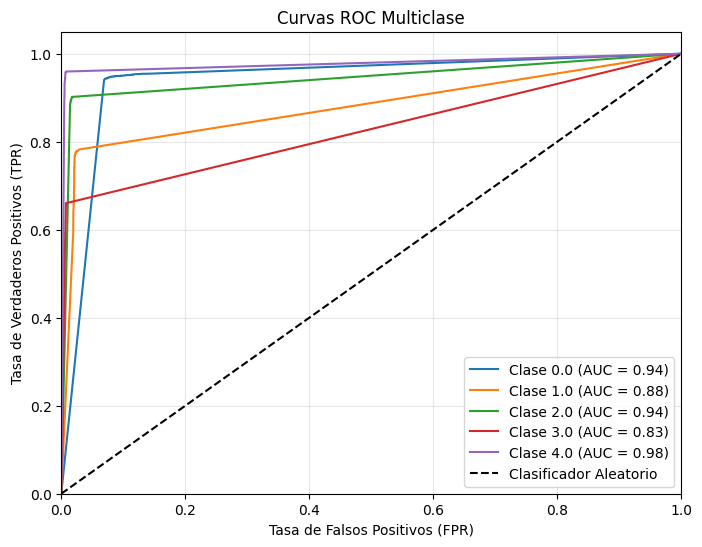

In [61]:
y_pred_proba = tree_results['y_pred_prob']

# Binarización de las clases
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Inicialización de diccionarios para almacenar métricas
fpr, tpr, roc_auc = {}, {}, {}

# Cálculo de las curvas ROC y AUC
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Clase {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Gráfica de la línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

No hay cambio en la discriminación (AUC) de las clases. ADASYN y SMOTE tienen el mismo rendimiento en este aspecto.

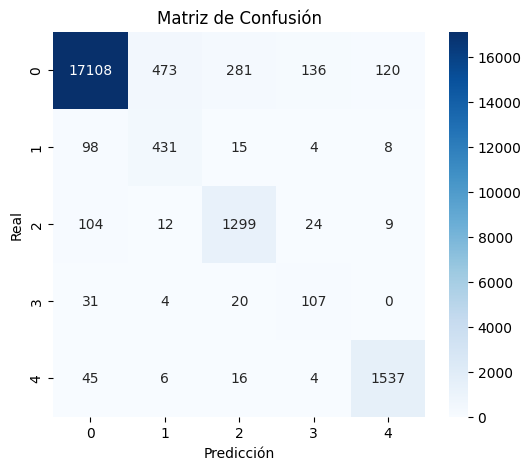

In [62]:
# Matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(tree_results["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Rendimiento muy similar. ADASYN mejora apenas para clase 3, pero empeora muy ligeramente en clase 1. En general, sin diferencias significativas.

In [63]:
print("Reporte de Clasificación:\n", tree_results["classification_report"])

Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     18118
         1.0       0.47      0.78      0.58       556
         2.0       0.80      0.90      0.84      1448
         3.0       0.39      0.66      0.49       162
         4.0       0.92      0.96      0.94      1608

    accuracy                           0.94     21892
   macro avg       0.71      0.85      0.76     21892
weighted avg       0.95      0.94      0.94     21892



**Conclusiones:**

Ambas técnicas ofrecen rendimiento muy similar.